In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn

In [2]:
transform = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
#     transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

full_dataset = torchvision.datasets.ImageFolder(root='/content/drive/My Drive/DL/faces94/', transform=transform)
print(len(full_dataset))
dataloader = torch.utils.data.DataLoader(full_dataset, batch_size=32, shuffle=True, num_workers=2)
print(len(dataloader))

device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")
print(device)

3059
96
cuda


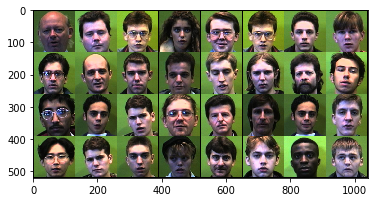

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.grid(False)
    plt.show()
    
# print(iter(dataloader).next()[0])
imshow(torchvision.utils.make_grid(iter(dataloader).next()[0]))

In [0]:
class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        self.encode = nn.Sequential(
            nn.Conv2d(3, 8, 5, 2),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            
            nn.Conv2d(8, 16, 5, 2),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            
            nn.Conv2d(16, 32, 5, 2),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            
            nn.Conv2d(32, 64, 5, 2),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            nn.Conv2d(64, 100, 4, 2),
            nn.BatchNorm2d(100),
            nn.ReLU(True)
        )
        
        self.decode = nn.Sequential(
            nn.ConvTranspose2d(100, 64, 4),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(64, 32, 6, 2),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(32, 16, 6, 2),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(16, 8, 7, 2),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(8, 3, 8, 2),
            nn.BatchNorm2d(3),
            nn.ReLU(True),
        )
        
    def forward(self, input):
        out = self.encode(input)
#         print(out.shape)
        return self.decode(out)

In [5]:
generator = Generator().to(device)
print(generator)
# print(generator(iter(dataloader).next()[0].to(device)))

Generator(
  (encode): Sequential(
    (0): Conv2d(3, 8, kernel_size=(5, 5), stride=(2, 2))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(8, 16, kernel_size=(5, 5), stride=(2, 2))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): Conv2d(64, 100, kernel_size=(4, 4), stride=(2, 2))
    (13): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace)
  )
  (decode): Sequential(
    (0): ConvTranspose2d(100, 64, kernel_size=(4, 4), stride=(1, 1))
    (1): B

In [0]:
class Discriminator(nn.Module):
  
  def __init__(self):
    super(Discriminator, self).__init__()
    
    self.main = nn.Sequential(
      nn.Conv2d(3, 8, 4, 2),
      nn.MaxPool2d(2),
      nn.ReLU(True),
        
      nn.Conv2d(8, 32, 4, 2),
      nn.MaxPool2d(2),
      nn.ReLU(True),
        
      nn.Conv2d(32, 1, 4, 2),  
      nn.MaxPool2d(2),
      nn.Sigmoid()
    )
    
    
  def forward(self, input):
    return self.main(input)

In [7]:
discriminator = Discriminator().to(device)
print(discriminator)
print(discriminator(iter(dataloader).next()[0].to(device)).shape)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 8, kernel_size=(4, 4), stride=(2, 2))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace)
    (3): Conv2d(8, 32, kernel_size=(4, 4), stride=(2, 2))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace)
    (6): Conv2d(32, 1, kernel_size=(4, 4), stride=(2, 2))
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Sigmoid()
  )
)
torch.Size([32, 1, 1, 1])


In [0]:
criterion = nn.BCELoss()
criterion2 = nn.MSELoss()

real_label = 1
fake_label = 0

lr = 0.0002

optimizerD = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizerG = torch.optim.Adam(generator.parameters(), lr=lr)

In [0]:
generated_images = list()

num_epochs = 100

noise = torch.rand(32, 3, 128, 128, device=device)

# generator.train()
# discriminator.train()
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
      if i<len(dataloader)-2:
        discriminator.zero_grad()
        real_cpu = data[0].to(device)

        b_size = real_cpu.size(0)

        label = torch.full((b_size,), real_label, device=device)
        output = discriminator(real_cpu).view(-1)
        
        errorD_real = criterion(output, label)
        errorD_real.backward()

        fake = generator(real_cpu)
        label.fill_(fake_label)
        output = discriminator(fake.detach()).view(-1)

        errorD_fake = criterion(output, label)
        errorD_fake.backward()

        errorD = errorD_real + errorD_fake
        optimizerD.step()


        generator.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = discriminator(fake).view(-1)
        # Calculate G's loss based on this output
#         errB = 0.001*criterion(output, label)
        errorG = 0.001*criterion(output, label) + criterion2(fake, real_cpu)
        # Calculate gradients for G
        errorG.backward()
        # Update G
        optimizerG.step()


#         print(i, real_cpu.shape)

        if i%120 == 0 or i==(len(dataloader)-2):
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f' % (epoch, num_epochs, i, len(dataloader),
                     errorD.item(), errorG.item()))
            img = fake.cpu().detach()
            imshow(torchvision.utils.make_grid(img, padding=2, normalize=True))
#             print(fake.cpu())
            print(torch.cuda.get_device_name(0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


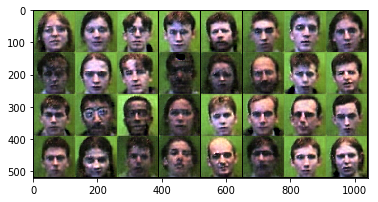

In [11]:
#eval modal
generator.eval()
for i, data in enumerate(dataloader, 0):
  real_cpu = data[0].to(device)
  out = generator(real_cpu)
  
  imshow(torchvision.utils.make_grid(out.cpu().detach()))
  break

In [0]:
#load modal

#generator
checkpoint = torch.load("/content/drive/My Drive/Colab Notebooks/checkpointA03G.pth.tar")
generator.load_state_dict(checkpoint['state_dict'])
optimizerG.load_state_dict(checkpoint['optimizer'])

#discriminator
checkpoint = torch.load("/content/drive/My Drive/Colab Notebooks/checkpointA03D.pth.tar")
discriminator.load_state_dict(checkpoint['state_dict'])
optimizerD.load_state_dict(checkpoint['optimizer'])

In [0]:
#saving checkpoint

import shutil
def save_checkpoint(state, is_best, filename='checkpointG.pth.tar'):
    torch.save(state, filename)
#     if is_best:
#         shutil.copyfile(filename, 'model_bestG.pth.tar')
   
#generator
save_checkpoint({
            'state_dict': generator.state_dict(),
            'optimizer' : optimizerG.state_dict(),
        }, True, "/content/drive/My Drive/Colab Notebooks/checkpointA03G.pth.tar")

#discriminator
save_checkpoint({
            'state_dict': discriminator.state_dict(),
            'optimizer' : optimizerD.state_dict(),
        }, True, "/content/drive/My Drive/Colab Notebooks/checkpointA03D.pth.tar")